In [12]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
import gdown
from tensorflow.keras.layers import Embedding, LSTM, SimpleRNN, Dense, Conv1D, MaxPooling1D

url = 'https://drive.google.com/file/d/1K1FYEcCnpQrQv3rHr2ozXXrILTOY3XF2/view?usp=share_link'
url2 = 'https://drive.google.com/file/d/1dKPZpvP8KPXqScIZR-GYGYhOSGLmndMe/view?usp=share_link'
output = 'best_model_no_pretrained_both.h5'
output2 = 'best_model_pretrained_embedding.h5'
gdown.download(url, output, quiet=False)
gdown.download(url2, output2, quiet=False)


/usr/local/lib/python3.10/dist-packages/gdown/parse_url.py:35: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=1K1FYEcCnpQrQv3rHr2ozXXrILTOY3XF2
  warnings.warn(
Downloading...
From: https://drive.google.com/file/d/1K1FYEcCnpQrQv3rHr2ozXXrILTOY3XF2/view?usp=share_link
To: /content/best_model_no_pretrained_both.h5
73.6kB [00:00, 14.9MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/parse_url.py:35: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=1dKPZpvP8KPXqScIZR-GYGYhOSGLmndMe
  warnings.warn(
Downloading...
From: https://drive.google.com/file/d/1dKPZpvP8KPXqScIZR-GYGYhOSGLmndMe/view?usp=share_link
To: /content/best_model_pretrained_embedding.h5
73.6kB [00:00, 13.5MB/s]


'best_model_pretrained_embedding.h5'

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

# Load the BBC dataset
bbc_data = pd.read_csv('https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv')

# Display the first 5 rows of the dataset
print(bbc_data.head())


        category                                               text
0           tech  tv future in the hands of viewers with home th...
1       business  worldcom boss  left books alone  former worldc...
2          sport  tigers wary of farrell  gamble  leicester say ...
3          sport  yeading face newcastle in fa cup premiership s...
4  entertainment  ocean s twelve raids box office ocean s twelve...


In [15]:
#Dataset Splitting for BBC Dataset
train_data, test_data = train_test_split(bbc_data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)


In [16]:
train_data

,category,text
1490,entertainment,farrell due to make us tv debut actor colin fa...
2001,business,china continues rapid growth china s economy h...
1572,business,ebbers aware of worldcom fraud former worldc...
1840,entertainment,school tribute for tv host carson more than 1 ...
610,tech,broadband fuels online expression fast web acc...
...,...,...
1638,sport,a november to remember last saturday one news...
1095,sport,african double in edinburgh world 5000m champi...
1130,tech,what price for trusted pc security you can ...
1294,sport,o driscoll/gregan lead aid stars ireland s bri...


In [17]:
# Display the number of samples in each set
print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Testing samples: {len(test_data)}")

Training samples: 1780
Validation samples: 222
Testing samples: 223


In [18]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['text'])

X_train = tokenizer.texts_to_sequences(train_data['text'])
X_val = tokenizer.texts_to_sequences(val_data['text'])
X_test = tokenizer.texts_to_sequences(test_data['text'])



In [19]:
# Pad the sequences
max_length = 500

X_train = pad_sequences(X_train, maxlen=max_length, padding='post', truncating='post')
X_val = pad_sequences(X_val, maxlen=max_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post', truncating='post')

In [20]:
# Prepare the target (sectionName) data
encoder = LabelEncoder()
encoder.fit(bbc_data['category'])
y_train = encoder.transform(train_data['category'])
y_val = encoder.transform(val_data['category'])
y_test = encoder.transform(test_data['category'])

In [21]:
# Prompt 14: Load Saved Models from Part 1
model_without_embeddings = load_model('/content/drive/MyDrive/best_model_no_pretrained_both.h5')
model_with_embeddings = load_model('/content/drive/MyDrive/best_model_pretrained_embedding.h5')

In [25]:
state_size = 128
epochs = 1
batch_size = 32

def build_cnn_model(use_cnn_before_lstm):
    model = Sequential()
    model.add(Embedding(len(tokenizer.word_index) + 1, state_size, input_length=max_length))
    if use_cnn_before_lstm:
        model.add(Conv1D(filters=64, kernel_size=3, activation="relu"))
        model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(state_size))
    model.add(Dense(len(encoder.classes_), activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

# Use of CNN as an additional layer before LSTM
cnn_lstm_model = build_cnn_model(True)
cnn_lstm_history = cnn_lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=32)
cnn_lstm_test_loss, cnn_lstm_test_acc = cnn_lstm_model.evaluate(X_test, y_test, verbose=0)

print("CNN as an additional layer before LSTM Test Accuracy:", cnn_lstm_test_acc)

56/56 [==============================] - 33s 538ms/step - loss: 1.5678 - accuracy: 0.2753 - val_loss: 1.5534 - val_accuracy: 0.2342
CNN as an additional layer before LSTM Test Accuracy: 0.27802690863609314


In [27]:
# Transfer model without embeddings
transfer_model_without_embeddings = Sequential([
    model_without_embeddings.layers[0],
    model_without_embeddings.layers[1],
    Flatten(),
    Dense(5, activation='softmax')
])

transfer_model_without_embeddings.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_without_embeddings = transfer_model_without_embeddings.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=2, batch_size=32)

# Evaluate the model on the test dataset
test_loss_without_embeddings, test_accuracy_without_embeddings = transfer_model_without_embeddings.evaluate(X_test, y_test)
print(f"Test loss without embeddings: {test_loss_without_embeddings}")
print(f"Test accuracy without embeddings: {test_accuracy_without_embeddings}")

# Transfer model with embeddings
transfer_model_with_embeddings = Sequential([
    model_with_embeddings.layers[0],
    model_with_embeddings.layers[1],
    Flatten(),
    Dense(5, activation='softmax')
])

transfer_model_with_embeddings.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_with_embeddings = transfer_model_with_embeddings.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=2, batch_size=32)

# Evaluate the model on the test dataset
test_loss_with_embeddings, test_accuracy_with_embeddings = transfer_model_with_embeddings.evaluate(X_test, y_test)
print(f"Test loss with embeddings: {test_loss_with_embeddings}")
print(f"Test accuracy with embeddings: {test_accuracy_with_embeddings}")


Epoch 1/2
56/56 [==============================] - 102s 2s/step - loss: 1.5508 - accuracy: 0.3022 - val_loss: 1.5186 - val_accuracy: 0.2883
Epoch 2/2
7/7 [==============================] - 2s 306ms/step - loss: 1.5249 - accuracy: 0.2601
Test loss without embeddings: 1.524852991104126
Test accuracy without embeddings: 0.2600896954536438
Epoch 1/2
56/56 [==============================] - 84s 1s/step - loss: 1.5617 - accuracy: 0.2742 - val_loss: 1.5562 - val_accuracy: 0.2838
Epoch 2/2
7/7 [==============================] - 2s 248ms/step - loss: 1.4919 - accuracy: 0.2960
Test loss with embeddings: 1.491922378540039
Test accuracy with embeddings: 0.2959641218185425


save best model

In [ ]:
cnn_lstm_model.save("part2.h5")

In [28]:
import matplotlib.pyplot as plt

def plot_history(histories, labels):
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    for history, label in zip(histories, labels):
        plt.plot(history.history['accuracy'], label=f'Training {label}')
        plt.plot(history.history['val_accuracy'], label=f'Validation {label}')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    for history, label in zip(histories, labels):
        plt.plot(history.history['loss'], label=f'Training {label}')
        plt.plot(history.history['val_loss'], label=f'Validation {label}')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()


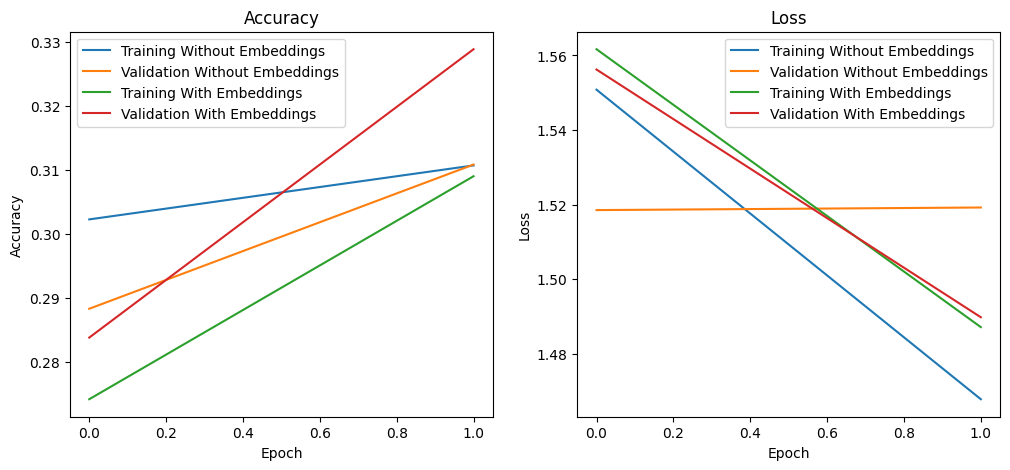

In [29]:
plot_history([history_without_embeddings, history_with_embeddings], ['Without Embeddings', 'With Embeddings'])